True

In [2]:
# def init_llm(
#         provider: Literal["openai", "anthropic", "google", "ollama"],
#         model: str,
#         temperature: float = 0.5,
# ):
#     if provider == "openai":
#         return ChatOpenAI(model=model, temperature=temperature)
#     elif provider == "anthropic":
#         return ChatAnthropic(model=model, temperature=temperature)
#     elif provider == "google":
#         return ChatGoogleGenerativeAI(model=model, temperature=temperature)
#     elif provider == "ollama":
#         return ChatOllama(model=model, temperature=temperature)

In [3]:
# llm = init_llm(
#     provider="ollama",
#     model="gpt-4o-mini",
#     temperature=0.5
# )

In [1]:
import os
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph.message import add_messages
from typing import TypedDict, List, Annotated, Literal, Union
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
import operator

from langgraph.types import Command, Send
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

from pydantic import BaseModel, Field

import uuid
from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
load_dotenv()
os.environ["LANGSMITH_TRACING"] = "true"

In [2]:
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [3]:
class Section(BaseModel):
    section_name: str = Field(..., description="The name of this section of the report without its number")
    sub_sections: List[str] = Field(..., description="Comprehensive descriptions of sub-sections, each combining the sub-section title and its bullet points into a fluid, natural-language description")

class Sections(BaseModel):
    sections: List[Section] = Field(..., description="A list of sections")

class Query(BaseModel):
    query: str = Field(..., description="A search query")

class Queries(BaseModel):
    queries: List[Query] = Field(..., description="A list of search queries")

class SearchResult(BaseModel):
    query: Query = Field(..., description="The search query that was used to retrieve the raw content")
    raw_content: list[str] = Field(..., description="The raw content retrieved from the search")

class Feedback(BaseModel):
    feedback: Union[str, bool] = Field(..., description="Feedback on the report structure. If the content is good for the section, return True (boolean), otherwise return a string of feedback on what is missing or incorrect.")

class SectionOutput(BaseModel):
    final_section_content: List[str] = Field(..., description="The final section content")

class ResponseFormat(BaseModel):
    """Respond to the user in this format."""

    status: Literal['input_required', 'completed', 'error'] = 'input_required'
    message: str

In [4]:
operator

<module 'operator' from '/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/operator.py'>

In [5]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    report_structure: str
    sections: List[Section]
    final_section_content: Annotated[List[str], operator.add] = []
    final_report_content: str
    structured_response: ResponseFormat

class ResearchState(TypedDict):
    section: Section
    knowledge: str
    reflection_feedback: Feedback = Feedback(feedback="")
    generated_queries: List[Query] = []
    searched_queries: Annotated[List[Query], operator.add] = []
    search_results: Annotated[List[SearchResult], operator.add] = []
    accumulated_content: str = ""
    reflection_count: int = 1
    final_section_content: List[str] = []

In [6]:
REPORT_STRUCTURE_PLANNER_SYSTEM_PROMPT_TEMPLATE = """You are an expert research assistant specialized in creating structured research frameworks. Your primary task is to generate a detailed, appropriate report structure based on a user's research query.

## Process to Follow:

1. UNDERSTAND THE REQUEST:
   - Carefully analyze the query provided by the user
   - Identify the type of research needed (exploratory, comparative, analytical, etc.)
   - Recognize the domain/field of the research

2. ASK CLARIFYING QUESTIONS:
   - If the user's request lacks sufficient detail, ask 2-3 focused questions to better understand:
     * Their background and expertise level
     * Their specific goals for the research
     * Any particular aspects they want to emphasize
     * Intended audience and purpose of the report
   - Prioritize questions that will significantly impact the report structure

3. GENERATE A COMPREHENSIVE REPORT STRUCTURE:
   - Create a detailed, hierarchical structure with:
     * Clear main sections (typically 5-12 depending on topic complexity)
     * Relevant subsections under each main section
     * Logical flow from introduction to conclusion
   - Adapt the structure to match the specific research type:
     * For learning/exploration topics: progress from fundamentals to advanced concepts
     * For comparison topics: use parallel structure across compared items
     * For data source exploration: organize by data types, sources, and methodologies
     * For implementation topics: follow a logical sequence from setup to advanced usage
   - Ensure the structure is comprehensive but focused on the user's specific needs

4. FORMAT THE RESPONSE:
   - Present the report structure as a hierarchical outline with clear section numbering
   - Use descriptive titles for each section and subsection
   - Include brief descriptions of key sections when helpful
   - Provide the structure in a clean, easy-to-read format

5. OFFER FOLLOW-UP ASSISTANCE:
   - Ask if any sections need adjustment or elaboration
   - Suggest specific modifications if you identify potential improvements

Remember that your task is ONLY to create the report structure, not to produce the actual research content. Focus on creating a comprehensive framework that will guide the user's research efforts.
"""

In [7]:
report_structure_planner_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(REPORT_STRUCTURE_PLANNER_SYSTEM_PROMPT_TEMPLATE),
    MessagesPlaceholder(variable_name="messages")
])

report_structure_planner_llm = report_structure_planner_system_prompt | llm

def report_structure_planner_node(state: AgentState, config: RunnableConfig):
    result = report_structure_planner_llm.invoke(state)
    return {"messages": [result]}

In [8]:
from pydantic import BaseModel, Field
from typing import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    """"Based on the user and the report planned converstation, decide whether further user input required or we can proceed to generate the entire report."""
    step: Literal["input_required", "do_research"] = Field(
        None, description="The next step in the routing process"
)

def human_feedback_node(state: AgentState, config: RunnableConfig)->Command[Literal["output", "section_formatter"]]:
    """Determine whether the retrieved documents are relevant to the question."""
    response = (
        llm
        .with_structured_output(Route).invoke(
            state["messages"]
        )
    )
    step = response.step

    if step == "input_required":
        return Command(
            goto="output"
        )
    else:
        return Command(
            goto="section_formatter",
        )

In [9]:
def output(state: AgentState, config: RunnableConfig):
    if(state.get('final_report_content',None)):
        return {"structured_response": ResponseFormat(status='completed',message=state['final_report_content'])}
    else:
        return {"structured_response": ResponseFormat(status='input_required',message=state['messages'][-1].content)}

In [10]:
# def human_feedback_node(state: AgentState, config: RunnableConfig)->Command[Literal["section_formatter", "report_structure_planner"]]:
#     human_message = input("Please provide feedback on the report structure (type 'continue' to continue): ")
#     report_structure = state.get("messages")[-1].content
#     if human_message == "continue":
#         return Command(
#             goto="section_formatter",
#             update={"messages": [HumanMessage(content=human_message)], "report_structure": report_structure}
#         )
#     else:
#         return Command(
#             goto="report_structure_planner",
#             update={"messages": [HumanMessage(content=human_message)]}
#         )

In [11]:
SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE = """You are a specialized parser that converts hierarchical report structures into a structured format. Your task is to analyze a report structure outline and extract the sections and subsections, while condensing the detailed bullet points into comprehensive subsection descriptions.

## Your Input:
You will receive a message containing a report structure with numbered sections and subsections, along with descriptive bullet points.

## Your Output Format:
You must output the result in the presented structure

# Processing Instructions:

- Identify each main section (typically numbered as 1, 2, 3, etc.)
- Extract the main section title without its number (e.g., "Introduction" from "1. Introduction")
- For each main section, identify all its subsections (typically numbered as 1.1, 1.2, 2.1, 2.2, etc.)
- For each subsection, incorporate its title AND the descriptive bullet points beneath it into a single comprehensive description
- Combine related concepts using commas and connecting words (and, with, including, etc.)
- Organize these into a JSON array with each object containing:
  "section_name": The main section title
  "sub_sections": An array of comprehensive subsection descriptions

# Content Condensation Guidelines:

- Transform subsection titles and their bullet points into fluid, natural-language descriptions
- Include all key concepts from the bullet points, but phrase them as part of a cohesive description
- Use phrases like "overview of", "including", "focusing on", "covering", etc. to connect concepts
- Maintain the key terminology from the original structure
- Aim for descriptive phrases rather than just lists of topics

# Example Transformation:
## From:
1. Introduction
   - 1.1 Background of Machine Learning
     - Overview of machine learning concepts
     - Importance of algorithms in machine learning
   - 1.2 Introduction to Support Vector Machines
     - Definition and significance
     - Historical context and development
To:
{{
  "section_name": "Introduction",
  "sub_sections": [
    "Background, overview and importance of Machine Learning", 
    "Introduction to Support Vector Machines, definition, significance and historical context"
  ]
}}

Remember to output only the valid JSON array containing all processed sections, with no additional commentary or explanations in your response.
"""

In [12]:

section_formatter_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE),
    # HumanMessagePromptTemplate.from_template(template="{report_structure}"),
    MessagesPlaceholder(variable_name="messages")
])

section_formatter_llm = section_formatter_system_prompt | llm.with_structured_output(Sections)

def section_formatter_node(state: AgentState, config: RunnableConfig) -> Command[Literal["research_agent"]]:
    result = section_formatter_llm.invoke(state)
    # return {"sections": result.sections}
    return Command(
        update={"sections": result.sections},
        goto=[
            Send(
                "research_agent",
                {
                    "section": s,
                }
            ) for s in result.sections
        ]
    )

In [13]:
SECTION_KNOWLEDGE_SYSTEM_PROMPT_TEMPLATE = """You are an expert research content generator. Your task is to create comprehensive, accurate, and well-structured content for a specific section of a research report. You will be provided with a section name and its subsections, and you should use your knowledge to create detailed content covering all aspects described.

## Input Format:
You will receive a section object with the following structure:
```json
{{
  "section_name": "The main section title",
  "sub_sections": [
    "Comprehensive description of subsection 1 including key points to cover",
    "Comprehensive description of subsection 2 including key points to cover",
    ...
  ]
}}
```

## Your Task:
Generate thorough, accurate content for this section that:

1. Begins with a brief introduction to the section topic
2. Covers each subsection in depth, maintaining the order provided
3. Includes relevant examples, explanations, and context
4. Incorporates current understanding and established knowledge on the topic
5. Maintains an academic and informative tone appropriate for a research report
6. Uses appropriate headings and subheadings for structure

## Content Guidelines:

### Depth and Breadth:
- Aim for comprehensive coverage of each subsection
- Include definitions of key terms and concepts
- Discuss current understanding and applications
- Address relationships between different concepts

### Structure:
- Use hierarchical formatting with clear headings
- Format the section title as a level 2 heading (##)
- Format each subsection as a level 3 heading (###)
- Use paragraphs to organize information logically
- Include transitional phrases between subsections

### Content Quality:
- Prioritize accuracy and clarity
- Provide specific examples to illustrate concepts
- Include relevant data points, statistics, or findings when applicable
- Maintain an objective, scholarly tone
- Avoid oversimplification of complex topics

### Technical Considerations:
- Use markdown formatting for headings, lists, and emphasis
- Include appropriate technical terminology
- Define specialized terms when they first appear
- Use code snippets or mathematical notation if appropriate for the topic

## Output Format:
Return only the generated content with appropriate markdown formatting. Do not include meta-commentary about your process or limitations. Your output should be ready to be inserted directly into the research report as a complete section.

Remember to rely solely on your existing knowledge. Do not fabricate specific studies, statistics, or quotations that you cannot verify.
"""

In [14]:
section_knowledge_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SECTION_KNOWLEDGE_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{section}"),
])

section_knowledge_llm = section_knowledge_system_prompt | llm

def section_knowledge_node(state: ResearchState, config: RunnableConfig):
    result = section_knowledge_llm.invoke(state)
    return {"knowledge": result.content}

In [15]:
QUERY_GENERATOR_SYSTEM_PROMPT_TEMPLATE = """You are a specialized search query generator for a research assistant system. Your task is to create highly effective search queries based on research section information. These queries will be used to retrieve relevant information from web search APIs to enhance research report content.

## Section Structure:
```json
{{
  "section_name": "The main section title",
  "sub_sections": [
    "Comprehensive description of subsection 1 including key points to cover",
    "Comprehensive description of subsection 2 including key points to cover",
    ...
  ]
}}
```

## Your Task:
Generate up to {max_queries} effective search queries that will retrieve the most relevant information for the given section and its subsections.

## Query Generation Process:

### For Initial Runs (no previous_queries or reflection_feedback):
1. Analyze the section name and all subsection descriptions thoroughly
2. Identify the core concepts, key terms, and relationships that need to be researched
3. Prioritize fundamental information needs first
4. Create specific, targeted queries for the most important information
5. Ensure coverage across all subsections, but prioritize depth over breadth
6. Include technical terminology and domain-specific language when appropriate

### For Subsequent Runs (with reflection_feedback):
1. Carefully analyze the reflection feedback to understand information gaps
2. Prioritize queries that address the specific missing information
3. Avoid generating queries too similar to previous_queries
4. Create more specialized or alternative phrasings to find the missing information
5. Use more technical or specific terminology if general queries were insufficient

## Query Construction Guidelines:

1. **Specificity**: Create targeted queries that are likely to return relevant results
   - Include specific technical terms rather than general descriptions
   - Incorporate domain knowledge and specialized terminology

2. **Diversity**: Ensure variety in your query approaches
   - Vary query structure (questions, keyword sets, specific facts to verify)
   - Target different aspects of the subsections
   - Include different perspectives or viewpoints when relevant

3. **Prioritization**: Order queries by importance
   - Place queries for fundamental or critical information first
   - Prioritize queries addressing explicit reflection feedback
   - Ensure the most important subsections are covered in the limited query count

4. **Effectiveness**: Optimize for search engine performance
   - Use search operators when helpful (quotes for exact phrases, etc.)
   - Keep queries concise but descriptive (typically 4-10 words)
   - Include year/recency indicators for time-sensitive topics

Remember: The most important queries should come first in your list, as the system may only use a subset of your generated queries based on the user's `max_queries` setting.
"""

In [16]:
# class ResearchState(TypedDict):
#     section: Section
#     knowledge: str
#     reflection_feedback: Feedback = Feedback(feedback="")
#     generated_queries: List[Query] = []
#     searched_queries: Annotated[List[Query], operator.add] = []
#     search_results: Annotated[List[SearchResult], operator.add] = []
#     accumulated_content: str = ""
#     reflection_count: int = 1
#     final_section_content: List[str] = []

In [17]:
query_generator_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(QUERY_GENERATOR_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Section: {section}\nPrevious Queries: {searched_queries}\nReflection Feedback: {reflection_feedback}"),
])

query_generator_llm = query_generator_system_prompt | llm.with_structured_output(Queries)

def query_generator_node(state: ResearchState, config: RunnableConfig):
    # print('=='*20,'Current State',state,'=='*20)
    result = query_generator_llm.invoke({
        "max_queries": config['configurable']['max_queries'],
        "reflection_feedback": state.get("reflection_feedback",Feedback(feedback="")),
        "searched_queries": state.get("searched_queries",[]),
        "section": state["section"]
    })
    return {"generated_queries": result.queries, "searched_queries": result.queries}


In [18]:
from langchain_tavily import TavilySearch

tavily_client = TavilySearch(
    topic="general",
    # include_answer=False,
    include_raw_content=True,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

def tavily_search_node(state: ResearchState, config: RunnableConfig):
    queries = state["generated_queries"]
    search_results = []
    for query in queries:
        raw_content = []
        response = tavily_client.invoke({"query": query.query, "max_results":config["configurable"]["search_depth"]})
        for result in response["results"]:
            raw_content.append(result['raw_content'] if(result.get('raw_content',None)) else result['content'])
        search_results.append(SearchResult(query=query, raw_content=raw_content))
    return {"search_results": search_results}

In [19]:
RESULT_ACCUMULATOR_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for curating and synthesizing raw search results. Your task is to transform unstructured web content into coherent, relevant, and organized information that can be used for report generation.

## Input
You will receive a list of SearchResult objects, each containing:
1. A Query object with the search query that was used
2. A list of raw_content strings containing text extracted from web pages

## Process
For each SearchResult provided:

1. ANALYZE the raw_content to identify:
   - Key information relevant to the associated query
   - Main concepts, definitions, and relationships
   - Supporting evidence, statistics, or examples
   - Credible sources or authorities mentioned

2. FILTER OUT:
   - Irrelevant website navigation elements and menus
   - Advertisements and promotional content
   - Duplicate information
   - Footers, headers, and other website template content
   - Form fields, subscription prompts, and UI text
   - Clearly outdated information

3. ORGANIZE the information into:
   - Core concepts and definitions
   - Key findings and insights
   - Supporting evidence and examples
   - Contrasting viewpoints (if present)
   - Contextual background information

4. SYNTHESIZE the content by:
   - Consolidating similar information from multiple sources
   - Resolving contradictions where possible (noting them explicitly otherwise)
   - Ensuring logical flow of information
   - Maintaining appropriate context

## Guidelines
- Focus on accuracy and relevance
- Maintain neutrality and balance in presenting information
- Preserve technical precision when dealing with specialized topics
- Note explicitly when information appears contradictory or uncertain
- When information appears to be from commercial sources, note potential bias
- Prioritize more recent information over older content
- Maintain proper attribution when specific sources are referenced
- NO IMPORTANT DETAILS SHOULD BE LEFT OUT. BE DETAILED AND THOROUGH.
"""

In [20]:
result_accumulator_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(RESULT_ACCUMULATOR_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{search_results}"),
])

result_accumulator_llm = result_accumulator_system_prompt | llm

def result_accumulator_node(state: ResearchState, config: RunnableConfig):
    result = result_accumulator_llm.invoke(state)
    return {"accumulated_content": result.content}

In [21]:
REFLECTION_FEEDBACK_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for critically evaluating search result content against report section requirements. You determine whether the accumulated content sufficiently addresses the intended section scope or requires additional information.

## Input
You will receive:
1. A Section object containing:
   - section_name: The name of the section without its number
   - sub_sections: A list of comprehensive descriptions of sub-sections
2. Accumulated content from search results related to this section

## Process
Carefully analyze the relationship between the section requirements and the accumulated content:

1. ASSESS COVERAGE by identifying:
   - How well the accumulated content addresses each sub-section
   - Key concepts or topics from the sub-sections that are missing in the content
   - Depth and breadth of information relative to what the section requires
   - Presence of all necessary perspectives, examples, and supporting evidence

2. EVALUATE QUALITY by considering:
   - Accuracy and currency of the information
   - Relevance to the specific section requirements
   - Logical organization and flow
   - Appropriate level of detail for the section's purpose
   - Balance and objectivity in presenting information

3. IDENTIFY GAPS by determining:
   - Missing key concepts or topics from the sub-sections
   - Insufficient depth in critical areas
   - Lack of supporting evidence or examples
   - Absence of important perspectives or contexts
   - Technical details required but not present

## Output
Produce a Feedback object with either:
- A boolean value of True if the content sufficiently meets the section requirements
- A string containing specific, actionable feedback on what is missing or needs improvement

## Guidelines for Feedback Generation
When providing string feedback:
- Be specific about what information is missing or inadequate
- Prioritize the most critical gaps first
- Frame feedback in a way that could guide further query generation
- Focus on content needs rather than stylistic concerns
- Indicate areas where contradictory information needs resolution
- Suggest specific types of information that would address the gaps

## Examples

Example 1 (Sufficient content):
```
True
```

Example 2 (Insufficient content):
```
"The content lacks specific examples of machine learning applications in healthcare. Additionally, there is insufficient information on the regulatory challenges of implementing AI in clinical settings. The ethical considerations sub-section requires more detailed discussion of patient privacy concerns and informed consent issues."
```

Example 3 (Partial coverage):
```
"While the general concepts of blockchain are well covered, the content is missing technical details on consensus mechanisms mentioned in sub-section 2. The comparison between proof-of-work and proof-of-stake systems is particularly needed. Additionally, more recent developments (post-2022) in scalability solutions should be included to fully address sub-section 3."
```
"""

In [22]:
reflection_feedback_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(REFLECTION_FEEDBACK_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Section: {section}\nAccumulated Content: {accumulated_content}"),
])

reflection_feedback_llm = reflection_feedback_system_prompt | llm.with_structured_output(Feedback)

def reflection_feedback_node(state: ResearchState, config: RunnableConfig) -> Command[Literal["final_section_formatter", "query_generator"]]:
    reflection_count = state.get("reflection_count",1)
    result = reflection_feedback_llm.invoke(state)
    feedback = result.feedback
    if (feedback == True) or (str(feedback).lower() == "true") or (reflection_count < config["configurable"]["num_reflections"]):
        return Command(
            update={"reflection_feedback": feedback},
            goto="final_section_formatter"
        )
    else:
        return Command(
            update={"reflection_feedback": feedback, "reflection_count": reflection_count + 1},
            goto="query_generator"
        )

In [23]:
FINAL_SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for synthesizing knowledge and research into comprehensive, authoritative section content for reports. Your task is to blend internal knowledge with curated search results to produce detailed, accurate, and well-structured section content.

## Input
You will receive:
1. Internal knowledge about the section topic (from the knowledge generator LLM)
2. Curated content from search results relevant to the section

## Process
Synthesize these information sources into cohesive section content by:

1. ANALYZE BOTH SOURCES to identify:
   - Core concepts, principles, and definitions
   - Key arguments, insights, and findings
   - Supporting evidence, examples, and case studies
   - Current trends, developments, and applications
   - Relevant controversies, debates, or alternative perspectives

2. INTEGRATE THE INFORMATION by:
   - Combining complementary information from both sources
   - Resolving any contradictions with reasoned analysis
   - Filling gaps in one source with information from the other
   - Ensuring proper flow and logical progression of ideas
   - Maintaining appropriate technical depth and precision

3. ENSURE COMPREHENSIVE COVERAGE by:
   - Addressing all key aspects of the section topic
   - Including sufficient detail on complex concepts
   - Providing necessary context for specialized information
   - Balancing breadth and depth appropriately
   - Incorporating relevant examples to illustrate key points

4. PRIORITIZE QUALITY by:
   - Favoring accuracy over quantity
   - Ensuring information is current and reflects the latest understanding
   - Presenting balanced perspectives on controversial topics
   - Maintaining appropriate technical language without unnecessary jargon
   - Supporting claims with evidence or reasoning

## Output
Produce detailed, well-structured section content that:
- Begins with a concise introduction to the topic
- Organizes information into coherent paragraphs with clear topic sentences
- Uses appropriate subheadings to improve readability and organization
- Includes relevant examples, case studies, or applications where appropriate
- Concludes with key takeaways or implications when relevant

## Guidelines
- Write in a clear, authoritative, and professional tone
- Use precise terminology appropriate to the subject matter
- Ensure logical flow between concepts and paragraphs
- Maintain appropriate technical depth based on the apparent audience level
- Include specific details, statistics, and examples where they add value
- Avoid unnecessary repetition while reinforcing key concepts
- Balance technical accuracy with readability
- Present multiple perspectives on contested topics where relevant
- Synthesize rather than merely concatenate information from the two sources
- Ensure the final content could stand alone as an authoritative resource on the topic

## Example Structure
[Section Title]

[Introductory paragraph providing overview and context]

[Subheading 1]
[Detailed exploration of first major aspect of the topic]
[Supporting evidence, examples, or case studies]

[Subheading 2]
[Detailed exploration of second major aspect of the topic]
[Supporting evidence, examples, or case studies]

[Additional subheadings as needed]

[Concluding paragraph summarizing key points and implications]"""

In [24]:
final_section_formatter_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(FINAL_SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Internal Knowledge: {knowledge}\nSearch Result content: {accumulated_content}"),
])

final_section_formatter_llm = final_section_formatter_system_prompt | llm

def final_section_formatter_node(state: ResearchState, config: RunnableConfig):
    result = final_section_formatter_llm.invoke(state)
    return {"final_section_content": [result.content]}


In [25]:
FINAL_REPORT_WRITER_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for assembling the final comprehensive research report from individual section contents. Your task is to transform separate section content into a cohesive, detailed, and authoritative research document that maintains the highest standards of academic and professional quality.

## Input
You will receive:
1. The complete report structure (including section names, numbers, and descriptions)
2. A list of strings containing the curated content for each section

## Process
Transform these components into a polished final research report by:

1. STRUCTURE AND ORGANIZATION
   - Follow the provided report structure exactly
   - Ensure proper hierarchical organization of sections and subsections
   - Create a coherent narrative flow throughout the entire document
   - Maintain consistent formatting and style across all sections
   - Implement appropriate transitions between sections to enhance readability

2. CONTENT INTEGRATION AND ENHANCEMENT
   - Preserve all technical details, examples, and evidence from section content
   - Ensure consistency in terminology and concepts across sections
   - Identify and resolve any contradictions or redundancies between sections
   - Add cross-references between related concepts in different sections
   - Ensure comprehensive coverage of all aspects of the research topic

3. ACADEMIC RIGOR AND DEPTH
   - Maintain precise technical language and domain-specific terminology
   - Preserve nuance and complexity while ensuring clarity
   - Ensure all claims are properly supported by evidence or reasoning
   - Maintain balanced presentation of competing perspectives where relevant
   - Preserve the depth and detail of specialized information

4. COMPLETENESS AND COMPREHENSIVENESS
   - Ensure no critical information is omitted or oversimplified
   - Verify that all subsections described in the report structure are fully addressed
   - Identify and address any remaining gaps in the integrated content
   - Ensure appropriate depth of coverage for each topic relative to its importance
   - Maintain appropriate balance between breadth and depth throughout

## Output
Produce a final research report that:
- Begins with an executive summary highlighting key findings and insights
- Includes a detailed table of contents reflecting the hierarchical structure
- Features comprehensive section content organized according to the provided structure
- Contains appropriate introduction and conclusion sections
- Maintains consistent academic/professional tone and formatting throughout
- Preserves all technical details, examples, data, and evidence
- Reads as a cohesive whole rather than a collection of separate sections

## Guidelines
- Format the document as a professional research paper or technical report
- Use consistent heading levels to reflect the hierarchical structure
- Maintain appropriate section and subsection numbering
- Include an executive summary that concisely presents key findings
- Create a detailed table of contents with page references
- Ensure logical progression and narrative continuity throughout
- Preserve technical precision while maintaining readability
- Use consistent citation format if references are included
- Include visualizations, tables, or diagrams described in section content
- Ensure comprehensive coverage without unnecessary repetition
- Address complex concepts with appropriate depth and nuance
- Maintain the highest standards of academic and professional writing

## Example Structure
```
# [REPORT TITLE]

## Executive Summary
[Concise overview of key findings and insights]

## Table of Contents
[Detailed hierarchical listing of all sections and subsections]

## 1. Introduction
[Context, scope, and purpose of the research]

## 2. [First Major Section]
### 2.1 [Subsection]
[Comprehensive content with preserved technical details]
### 2.2 [Subsection]
[Comprehensive content with preserved technical details]

## 3. [Second Major Section]
### 3.1 [Subsection]
[Comprehensive content with preserved technical details]
### 3.2 [Subsection]
[Comprehensive content with preserved technical details]

[Additional sections as specified in the report structure]

## N. Conclusion
[Summary of key findings, implications, and potential future directions]

## Appendices (if applicable)
[Supplementary material, methodological details, etc.]
```
"""

In [26]:
final_report_writer_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(FINAL_REPORT_WRITER_SYSTEM_PROMPT_TEMPLATE),
    MessagesPlaceholder(variable_name="messages"),
    HumanMessagePromptTemplate.from_template(template="The above contents covers the report structure\nSection Contents: {final_section_content}"),
])

final_report_writer_llm = final_report_writer_system_prompt | llm

def final_report_writer_node(state: AgentState, config: RunnableConfig):
    result = final_report_writer_llm.invoke(state)
    return {"final_report_content": result.content}

In [27]:
research_builder = StateGraph(ResearchState, output=SectionOutput)

research_builder.add_node("section_knowledge", section_knowledge_node)
research_builder.add_node("query_generator", query_generator_node)
research_builder.add_node("tavily_search", tavily_search_node)
research_builder.add_node("result_accumulator", result_accumulator_node)
research_builder.add_node("reflection", reflection_feedback_node)
research_builder.add_node("final_section_formatter", final_section_formatter_node)

research_builder.add_edge(START, "section_knowledge")
research_builder.add_edge("section_knowledge", "query_generator")
research_builder.add_edge("query_generator", "tavily_search")
research_builder.add_edge("tavily_search", "result_accumulator")
research_builder.add_edge("result_accumulator", "reflection")
research_builder.add_edge("final_section_formatter", END)




memory_saver = MemorySaver()

builder = StateGraph(AgentState)

builder.add_node("report_structure_planner", report_structure_planner_node)
builder.add_node("human_feedback", human_feedback_node)
builder.add_node("section_formatter", section_formatter_node)
builder.add_node("research_agent", research_builder.compile())
builder.add_node("final_report_writer", final_report_writer_node)
builder.add_node("output", output)

builder.set_entry_point("report_structure_planner")
builder.add_edge("report_structure_planner", "human_feedback")
builder.add_edge("research_agent", "final_report_writer")
builder.add_edge("final_report_writer", "output")
builder.add_edge("output", END)

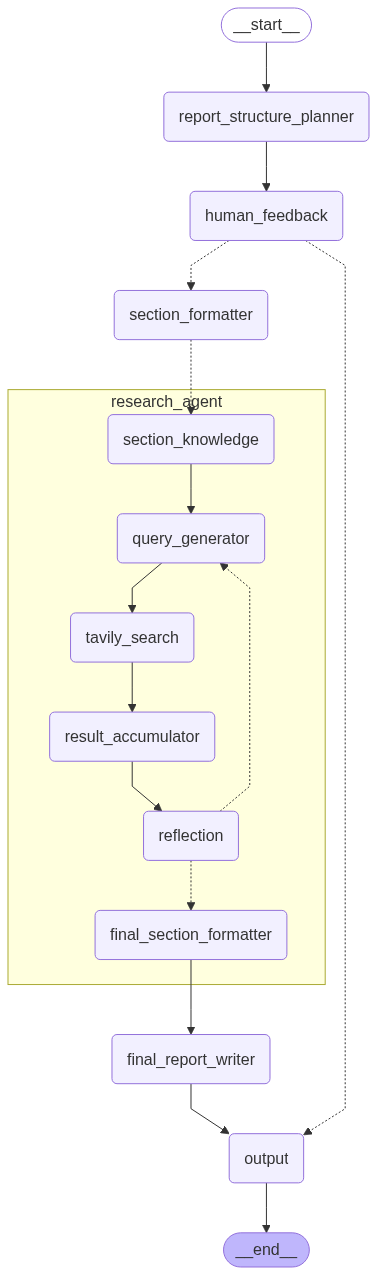

In [28]:
graph = builder.compile(checkpointer=memory_saver)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [29]:
user_input = "What are the steps taken by india after 2001 parliament terrorist attack."

config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
        "max_queries": 3,
        "search_depth": 2,
        "num_reflections": 2
    }
}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What are the steps taken by india after 2001 parliament terrorist attack.
================================== Ai Message ==================================

Okay, I can create a report structure outlining the steps taken by India following the 2001 Parliament terrorist attack. To make this structure most useful for you, could you clarify a couple of things?

1.  Are you interested in *all* the steps taken (diplomatic, legal, security, etc.) or are you focusing on a specific area, such as security reforms or legislative changes?
2.  Do you want a detailed analysis of the effectiveness/impact of each step, or a more descriptive overview of what actions were taken?

Here's a potential report structure based on a broad interpretation of your request:

**Report Structure: Steps Taken by India After the 2001 Parliament Terrorist Attack**

**1. Introduction**
    *   1.1. Background of the 2001 Parliament Attack


In [30]:
print(event['structured_response'].message)

```
# Analysis of India's Response to the 2001 Parliament Terrorist Attack

## Executive Summary

This report provides a structured analysis of India's response to the 2001 Parliament terrorist attack. It examines the scope and level of detail required for a comprehensive understanding, focusing on both the breadth (diplomatic, military, legal, and internal security actions) and depth (broad overview versus detailed policy changes) of the analysis. The report emphasizes a user-centric approach to ensure the analysis meets specific needs and objectives, tailoring the structure and content for maximum impact and strategic decision-making. Key elements of effective report generation, including data analysis, visualization, and contextual understanding, are discussed. The report also addresses potential challenges in creating custom reports, such as data quality, integration complexities, and user adoption, and offers solutions to overcome these hurdles. By focusing on user needs and emplo

In [30]:
user_input = "This looks good please proceed without any changes."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    print(event)

{'messages': [HumanMessage(content='What are the steps taken by india after 2001 parliament terrorist attack.', additional_kwargs={}, response_metadata={}, id='7a82010f-bfd9-40a4-81a1-cdcf8859debb'), AIMessage(content="Okay, I can create a report structure outlining the steps taken by India following the 2001 Parliament terrorist attack. To make this structure most useful for you, could you clarify a couple of things?\n\n1.  Are you interested in *all* the steps taken (diplomatic, legal, security, etc.) or are you focusing on a specific area, such as security reforms or legislative changes?\n2.  Do you want a detailed analysis of the effectiveness/impact of each step, or a more descriptive overview of what actions were taken?\n\nHere's a potential report structure based on a broad interpretation of your request:\n\n**Report Structure: Steps Taken by India After the 2001 Parliament Terrorist Attack**\n\n**1. Introduction**\n    *   1.1. Background of the 2001 Parliament Attack\n        

In [31]:
print(event['structured_response'].message)

Okay, I will now assemble the final research report based on the provided structure and content. This will be a comprehensive document, incorporating all the sections and subsections as outlined, and integrating the provided content into a cohesive and well-formatted report.

```
# Steps Taken by India After the 2001 Parliament Terrorist Attack

## Executive Summary

The 2001 Parliament Attack was a pivotal moment in India's history, exposing vulnerabilities in its national security apparatus and triggering a comprehensive overhaul of security protocols, legislative measures, and diplomatic strategies. This report provides a detailed analysis of the events leading up to and following the attack, including the immediate aftermath, the strengthening of national security infrastructure, legislative and legal responses, diplomatic initiatives, economic measures, and the resulting social and political impacts. Key findings include the implementation of stricter anti-terrorism laws, enhanced